## Импортирование необходимых библиотек

In [407]:
from PIL import Image
from glob import glob
import time
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torchsummary import summary
from torchvision import transforms as T
import pickle
from sklearn.metrics import classification_report
from PIL import Image
from tqdm.auto import tqdm
from IPython.display import clear_output
import matplotlib.pyplot as plt
import os

from random import randint
from io import BytesIO

from IPython.display import display
from IPython.display import Image as Img

## Чтение тренировочной и тестовой выборки

Инструкция для скачивания и загрузки фотографий в Сolab находится в github

In [476]:
heigth_width = 128

CLASSES = ['Jet', 'Drone', 'Helicopter'] # Здесь требуется указать ваши классы

images = []
images_t = []
classes = []
classes_t = []

for CLASS in range(0, len(CLASSES)):
  path_class_1 = "/media/system/SSD_1TB/Dataset/%s/*.*"%CLASSES[CLASS]
  #print(path_class_1)
  i=0
  for photo in glob(path_class_1):
    #   print(photo)
      i+=1
      img = Image.open(photo).convert('RGB')
      img = img.resize((heigth_width, heigth_width), Image.ANTIALIAS)
      if i > int(len(os.listdir("/media/system/SSD_1TB/Dataset/%s/"%CLASSES[CLASS]))*0.8):
          images_t.append(np.asarray(img))
          classes_t.append(np.asarray(CLASS))
      else:
          images.append(np.asarray(img))
          classes.append(np.asarray(CLASS))

    
train_X = np.array(images)
train_y = np.array(classes)

test_X = np.array(images_t)
test_y = np.array(classes_t)

# train_X = data_train['data'].reshape(-1, 3, 32, 32)
# train_X = np.transpose(train_X, [0, 2, 3, 1]) # NCHW -> NHWC
# train_y = np.array(data_train['fine_labels'])
# mask = np.isin(train_y, CLASSES)
# train_X = train_X[mask].copy()
# train_y = train_y[mask].copy()
# train_y = np.unique(train_y, return_inverse=1)[1]
# del data_train

# test_X = data_test['data'].reshape(-1, 3, 32, 32)
# test_X = np.transpose(test_X, [0, 2, 3, 1])
# test_y = np.array(data_test['fine_labels'])
# mask = np.isin(test_y, CLASSES)
# test_X = test_X[mask].copy()
# test_y = test_y[mask].copy()
# test_y = np.unique(test_y, return_inverse=1)[1]
# del data_test
# Image.fromarray(train_X[50]).resize((256,256))
print(np.shape(train_X))
print(np.shape(train_y))
print(np.shape(test_X))
print(np.shape(test_y))

# train_X =  train_X.reshape(-1, 3, 32, 32)
# train_X = np.transpose(train_X, [0,3,1,2])
# test_X = train_X.reshape(-1, 3, 32, 32)
# test_X = np.transpose(test_X, [0,3,1,2])

print(np.shape(train_X))
print(np.shape(test_X))
r = randint(1,266)

(266, 128, 128, 3)
(266,)
(68, 128, 128, 3)
(68,)
(266, 128, 128, 3)
(68, 128, 128, 3)


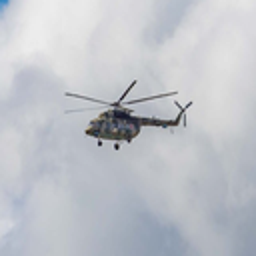

In [477]:
Image.fromarray(train_X[r]).resize((256,256))

###Приведение фотографий к требуемому размеру

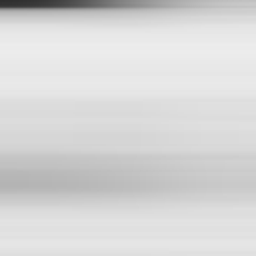

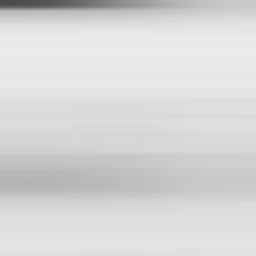

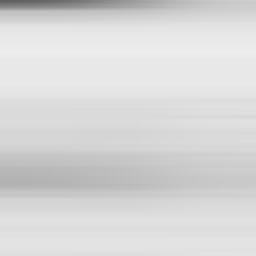

In [478]:


def display_img_array(ima):
    im = PIL.Image.fromarray(ima)
    bio = BytesIO()
    im.save(bio, format='png')
    display(Img(bio.getvalue(), format='png'))

# for ima in images:
#     display_img_array(ima)


# images = [Image.fromarray(train_X[r][0]).resize((256,256)), Image.fromarray(train_X[r][1]).resize((256,256)), Image.fromarray(train_X[r][2]).resize((256,256))]

for i in range(0,3):
    im = PIL.Image.fromarray(train_X[r][i]).resize((256,256))
    bio = BytesIO()
    im.save(bio, format='png')
    display(Img(bio.getvalue(), format='png'))



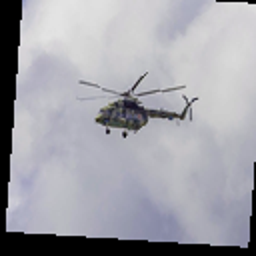

In [496]:




transform = T.Compose([
     T.ColorJitter(brightness=0.1, contrast=0.2, saturation=0.1, hue=0.1),
     T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05),
                    shear=1),
])

PIL.Image.fromarray((transform(torch.Tensor(train_X[r]).permute(2, 0, 1)/255.).\
                 permute(1, 2, 0).numpy()*255.).astype(np.uint8)).\
                 resize((256, 256))

##Создание Pytorch DataLoader'a

In [497]:
batch_size = 128
dataloader = {}
example = torch.Tensor
for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
                        ['train', 'test']):
    example = tensor_x
    tensor_x = torch.Tensor(X)
    tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
                                     num_classes=len(CLASSES))/1.
    dataset = TensorDataset(tensor_x, tensor_y)
    dataloader[part] = DataLoader(dataset, batch_size=batch_size,
                                  prefetch_factor=8 if part=='train' else 2,
                                  num_workers=2, persistent_workers=True,
                                  shuffle=True) # создание экземпляра класса DataLoader
dataloader

{'train': <torch.utils.data.dataloader.DataLoader at 0x7231ffb4ab60>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7231ff666800>}

In [498]:
# batch_size = 32
# dataloader = {}
# for (X, y), part in zip([(train_X, train_y), (test_X, test_y)],
#                         ['train', 'test']):
#     tensor_x = torch.Tensor(X)
#     tensor_y = F.one_hot(torch.Tensor(y).to(torch.int64),
#                                      num_classes=len(CLASSES))/1.
#     dataset = TensorDataset(tensor_x, tensor_y) # создание объекта датасета
#     dataloader[part] = DataLoader(dataset, batch_size=batch_size, shuffle=True) # создание экземпляра класса DataLoader
# dataloader
example
print(np.shape(example))

torch.Size([266, 128, 128, 3])


##Создание Pytorch модели многослойного перцептрона с одним скрытым слоем

In [499]:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.tensor(mean).to(device)
        self.std = torch.tensor(std).to(device)

    def forward(self, input):
        x = input / 255.0
        x = x - self.mean
        x = x / self.std
        return x.permute(0, 3, 1, 2) # nhwc -> nm


model = torch.hub.load("chenyaofo/pytorch-cifar-models",
                       "cifar100_mobilenetv2_x0_5",
                    #    'cifar100_resnet20',
                       pretrained=True)
model.to(device)
new_model = nn.Sequential(
    Normalize([0.5074,0.4867,0.4411],[0.2011,0.1987,0.2025]),# https://blog.jovian.ai/image-classification-of-cifar100-dataset-using-pytorch-8b7145242df1
    model
).to(device)
new_model


Using cache found in /home/system/.cache/torch/hub/chenyaofo_pytorch-cifar-models_master


Sequential(
  (0): Normalize()
  (1): MobileNetV2(
    (features): Sequential(
      (0): ConvBNActivation(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): ConvBNActivation(
            (0): Conv2d(8, 48, kernel_size=(1, 1

In [500]:

# print(new_model(torch.rand(1, 64, 64, 3).to(device)))
summary(new_model, input_size=(64,64,3))
# new_model

# summary(model, input_size=(3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 64, 64]               0
            Conv2d-2           [-1, 16, 64, 64]             432
       BatchNorm2d-3           [-1, 16, 64, 64]              32
             ReLU6-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 16, 64, 64]             144
       BatchNorm2d-6           [-1, 16, 64, 64]              32
             ReLU6-7           [-1, 16, 64, 64]               0
            Conv2d-8            [-1, 8, 64, 64]             128
       BatchNorm2d-9            [-1, 8, 64, 64]              16
 InvertedResidual-10            [-1, 8, 64, 64]               0
           Conv2d-11           [-1, 48, 64, 64]             384
      BatchNorm2d-12           [-1, 48, 64, 64]              96
            ReLU6-13           [-1, 48, 64, 64]               0
           Conv2d-14           [-1, 48,

In [501]:
## mobilenetv2
in_features = new_model[1].classifier[1].in_features
new_model[1].classifier[1] = nn.Linear(in_features=in_features,
                                      out_features=len(CLASSES),
                                      bias=True)
## resnet20
# in_features = new_model[1].fc.in_features
# new_model[1].fc = nn.Linear(in_features=in_features,
#                             out_features=len(CLASSES),
#                             bias=True)

new_model.to(device)
summary(new_model, input_size=(64, 64, 3))
print(new_model(torch.rand(1, 64, 64, 3).to(device)))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 64, 64]               0
            Conv2d-2           [-1, 16, 64, 64]             432
       BatchNorm2d-3           [-1, 16, 64, 64]              32
             ReLU6-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 16, 64, 64]             144
       BatchNorm2d-6           [-1, 16, 64, 64]              32
             ReLU6-7           [-1, 16, 64, 64]               0
            Conv2d-8            [-1, 8, 64, 64]             128
       BatchNorm2d-9            [-1, 8, 64, 64]              16
 InvertedResidual-10            [-1, 8, 64, 64]               0
           Conv2d-11           [-1, 48, 64, 64]             384
      BatchNorm2d-12           [-1, 48, 64, 64]              96
            ReLU6-13           [-1, 48, 64, 64]               0
           Conv2d-14           [-1, 48,

In [502]:
print("Обучаемые параметры:")
keep_last = 10
total = len([*new_model.named_parameters()])
params_to_update = []
for i, (name, param) in enumerate(new_model.named_parameters()):
    if i < total - keep_last:
        param.requires_grad = False 
    else:
        params_to_update.append(param)
        param.requires_grad = True
        print("\t",name)
summary(new_model, input_size=(64, 64, 3))

Обучаемые параметры:
	 1.features.17.conv.1.1.weight
	 1.features.17.conv.1.1.bias
	 1.features.17.conv.2.weight
	 1.features.17.conv.3.weight
	 1.features.17.conv.3.bias
	 1.features.18.0.weight
	 1.features.18.1.weight
	 1.features.18.1.bias
	 1.classifier.1.weight
	 1.classifier.1.bias
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         Normalize-1            [-1, 3, 64, 64]               0
            Conv2d-2           [-1, 16, 64, 64]             432
       BatchNorm2d-3           [-1, 16, 64, 64]              32
             ReLU6-4           [-1, 16, 64, 64]               0
            Conv2d-5           [-1, 16, 64, 64]             144
       BatchNorm2d-6           [-1, 16, 64, 64]              32
             ReLU6-7           [-1, 16, 64, 64]               0
            Conv2d-8            [-1, 8, 64, 64]             128
       BatchNorm2d-9            [-1, 8, 64, 64]              16
 Inve

##Выбор функции потерь и оптимизатора градиентного спуска

In [503]:
# добавляем сглаживание целевых меток, это увеличит значение функции потерь
# но полученная модель будет более устойчивой к выбросам в обучающей выборке
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# используется SGD c momentum и L2-регуляризацией весов
# optimizer = optim.SGD(params_to_update, lr=3e-3, momentum=0.9,
#                       weight_decay=1e-7)
optimizer = optim.Adam(params_to_update, lr=0.005,betas=(0.9,0.999),eps=1e-08 ,
                      weight_decay=0)
# добавляем постепенное уменьшение шага обучения каждые 20 эпох
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

##Обучение модели по эпохам

Эпоха: 250
Лучшая доля правильных ответов: 79.4117660522461
Текущая доля правильных ответов: 75.0


  0%|          | 0/750 [00:00<?, ?it/s]

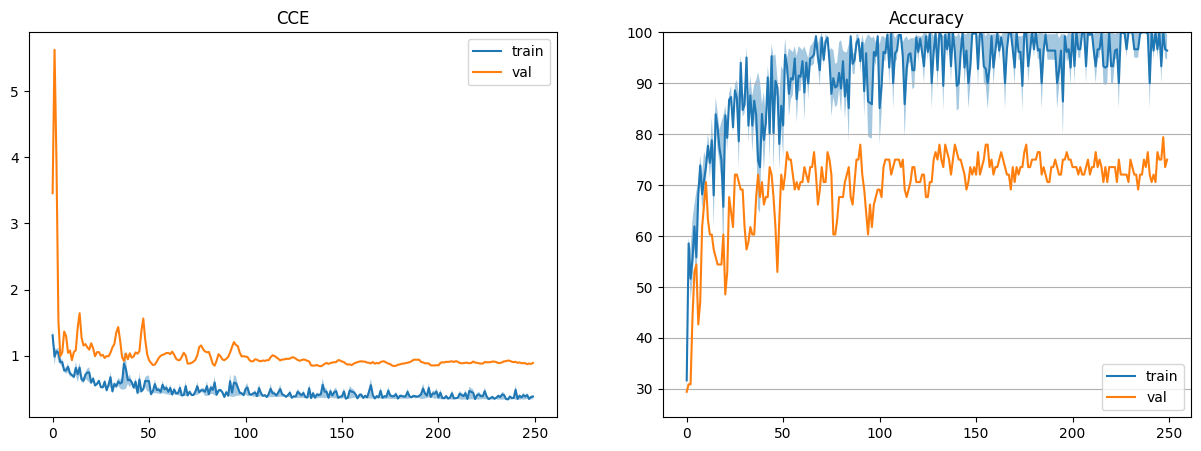

Обучение закончено за 2879.3354172706604 секунд


In [504]:
EPOCHS = 250
REDRAW_EVERY = 1
steps_per_epoch = len(dataloader['train'])
steps_per_epoch_val = len(dataloader['test'])
# NEW
pbar = tqdm(total=EPOCHS*steps_per_epoch)
losses = []
losses_val = []
passed = 0
# для создания чекпоинта
best_acc = 0
checkpoint_path = 'cifar_cnn_fine.pth' 
for epoch in range(EPOCHS):  # проход по набору данных несколько раз
    tmp = []
    new_model.train()
    for i, batch in enumerate(dataloader['train'], 0):
        # получение одного минибатча; batch это двуэлементный список из [inputs, labels]
        inputs, labels = batch
        # на GPU
        inputs, labels = inputs.to(device), labels.to(device)

        # очищение прошлых градиентов с прошлой итерации
        optimizer.zero_grad()

        # прямой + обратный проходы + оптимизация
        outputs = new_model(inputs)
        loss = criterion(outputs, labels)
        #loss = F.cross_entropy(outputs, labels)
        loss.backward()
        optimizer.step()

        # для подсчёта статистик
        accuracy = (labels.detach().argmax(dim=-1)==outputs.detach().argmax(dim=-1)).\
                    to(torch.float32).mean().cpu()*100
        tmp.append((loss.item(), accuracy.item()))
        pbar.update(1)
    losses.append((np.mean(tmp, axis=0),
                   np.percentile(tmp, 25, axis=0),
                   np.percentile(tmp, 75, axis=0)))
    scheduler.step() # обновляем learning_rate каждую эпоху
    tmp = []
    new_model.eval()
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader['test'], 0):
            inputs, labels = data
            # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs)
            loss = criterion(outputs, labels)
            accuracy = (labels.argmax(dim=-1)==outputs.argmax(dim=-1)).\
                        to(torch.float32).mean().cpu()*100
            tmp.append((loss.item(), accuracy.item()))
    losses_val.append((np.mean(tmp, axis=0),
                       np.percentile(tmp, 25, axis=0),
                       np.percentile(tmp, 75, axis=0)))
    # сохранение чекпоинта
    acc = losses_val[-1][0][1]
    if acc > best_acc:
        best_acc = acc
        torch.save(new_model.state_dict(), checkpoint_path)
    # обновление графиков
    if (epoch+1) % REDRAW_EVERY != 0:
        continue
    clear_output(wait=False)
    print('Эпоха: %s\n'
          'Лучшая доля правильных ответов: %s\n'
          'Текущая доля правильных ответов: %s' % (epoch+1, best_acc, acc))
    passed += pbar.format_dict['elapsed']
    pbar = tqdm(total=EPOCHS*steps_per_epoch, miniters=5)
    pbar.update((epoch+1)*steps_per_epoch)
    x_vals = np.arange(epoch+1)
    _, ax = plt.subplots(1, 2, figsize=(15, 5))
    stats = np.array(losses)
    stats_val = np.array(losses_val)
    ax[1].set_ylim(stats_val[:, 0, 1].min()-5, 100)
    ax[1].grid(axis='y')
    for i, title in enumerate(['CCE', 'Accuracy']):
        ax[i].plot(x_vals, stats[:, 0, i], label='train')
        ax[i].fill_between(x_vals, stats[:, 1, i],
                           stats[:, 2, i], alpha=0.4)
        ax[i].plot(x_vals, stats_val[:, 0, i], label='val')
        ax[i].fill_between(x_vals,
                           stats_val[:, 1, i],
                           stats_val[:, 2, i], alpha=0.4)
        ax[i].legend()
        ax[i].set_title(title)
    plt.show()
new_model.load_state_dict(torch.load(checkpoint_path))
print('Обучение закончено за %s секунд' % passed)

##Проверка качества модели по классам на обучающей и тестовой выборках

In [506]:
for part in ['train', 'test']:
    y_pred = []
    y_true = []
    with torch.no_grad(): # отключение автоматического дифференцирования
        for i, data in enumerate(dataloader[part], 0):
            inputs, labels = data
             # на GPU
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = new_model(inputs).detach().cpu().numpy()
            y_pred.append(outputs)
            y_true.append(labels.cpu().numpy())
        y_true = np.concatenate(y_true)
        y_pred = np.concatenate(y_pred)
        print(part)
        print(classification_report(y_true.argmax(axis=-1), y_pred.argmax(axis=-1),
                                    digits=4, target_names=list(map(str, CLASSES))))
        print('-'*50)

train
              precision    recall  f1-score   support

         Jet     1.0000    1.0000    1.0000        82
       Drone     1.0000    1.0000    1.0000        83
  Helicopter     1.0000    1.0000    1.0000       101

    accuracy                         1.0000       266
   macro avg     1.0000    1.0000    1.0000       266
weighted avg     1.0000    1.0000    1.0000       266

--------------------------------------------------
test
              precision    recall  f1-score   support

         Jet     0.7273    0.7619    0.7442        21
       Drone     0.8095    0.8095    0.8095        21
  Helicopter     0.8400    0.8077    0.8235        26

    accuracy                         0.7941        68
   macro avg     0.7923    0.7930    0.7924        68
weighted avg     0.7958    0.7941    0.7947        68

--------------------------------------------------


##Сохранение модели в ONNX

In [455]:
# сохраниение модели
# ПЕРВЫЙ СПОСОБ: сохранение параметров
PATH = 'cifar_dz_fine.pth'
torch.save(new_model.state_dict(), PATH)

In [456]:
# входной тензор для модели
# print(new_model(torch.rand(1, 64, 64, 3).to(device)))
x = torch.randn(1, 64, 64, 3, requires_grad=True).to(device)
# torch_out = model(x)

# экспорт модели
torch.onnx.export(new_model,               # модель
                  x,                   # входной тензор (или кортеж нескольких тензоров)
                  "cifar100_DZ_tmp_4h.onnx", # куда сохранить (либо путь к файлу либо fileObject)
                  export_params=True,  # сохраняет веса обученных параметров внутри файла модели
                  opset_version=9,     # версия ONNX
                  do_constant_folding=True,  # следует ли выполнять укорачивание констант для оптимизации
                  input_names = ['input'],   # имя входного слоя
                  output_names = ['output'],  # имя выходного слоя
                  dynamic_axes={'input' : {0 : 'batch_size'},    # динамичные оси, в данном случае только размер пакета
                                'output' : {0 : 'batch_size'}})